# Auto-encoder


In [55]:
###### -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import keras 
import time

from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import Dense, Dropout, Activation, GaussianNoise
from keras.optimizers import SGD

from src.utils import ber_performance, get_basic_channel_fct, show_ber, get_all_possible_words

# Configuration
MODULATION = 'BPSK'
FEC_MATRIX = 'POLAR_8_16'

# Load data
k = 8
n = 16

elements = list(get_all_possible_words(k))

def train_autoencoder(EbN0dB, nb_epochs=10_000):
    # Create models
    # Encoder
    encoder_model=Sequential()
    encoder_model.add(Dense(128, activation='relu', input_dim=k))
    encoder_model.add(Dense(64, activation='relu'))
    encoder_model.add(Dense(32, activation='relu'))
    
    encoder_model.add(Dense(n, activation='tanh'))

    # Decoder
    decoder_model=Sequential()
    decoder_model.add(Dense(32, activation='relu', input_dim=n))
    decoder_model.add(Dense(64, activation='relu'))
    decoder_model.add(Dense(128, activation='relu'))
    decoder_model.add(Dense(k, activation='tanh'))

    # Merge both to autoencoder
    noise_std = np.sqrt(0.5*(n/k)*(1 / 1)*(1/10**(EbN0dB/10)))
    noisy_model=Sequential()
    noisy_model.add(encoder_model)
    noisy_model.add(GaussianNoise(noise_std, input_shape=(n,)))
    noisy_model.add(decoder_model)

    noisy_model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['accuracy']
    )
    
    print(noisy_model.summary())
    
    t = time.time()
    noisy_history = noisy_model.fit(
        np.array(elements), 
        np.array(elements), 
        epochs=nb_epochs, 
        verbose=0
    )
    print(f'Elapsed : {np.round(time.time() - t, 2)} s')
    
    # Save models
    encoder_model.save(f'networks/autoencoder/autoencoder_encoder_{EbN0dB}-{nb_epochs}.h5')
    decoder_model.save(f'networks/autoencoder/autoencoder_decoder_{EbN0dB}-{nb_epochs}.h5')

if __name__ == '__main__':
    train_autoencoder(5)
    

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_46 (Sequential)   (None, 16)                10448     
_________________________________________________________________
gaussian_noise_16 (GaussianN (None, 16)                0         
_________________________________________________________________
sequential_47 (Sequential)   (None, 8)                 10440     
Total params: 20,888
Trainable params: 20,888
Non-trainable params: 0
_________________________________________________________________
None
Elapsed : 525.92 s


C:\Users\Thibault\Anaconda3\envs\PythonGPU\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '



Start simulation with network trained at 5-10000 dB
Start EbN0 1/10 [-5.0] /1000 [1694] | Ended in 0.27 s
Start EbN0 2/10 [-3.56] /1000 [1411] | Ended in 0.1 s
Start EbN0 3/10 [-2.11] /1000 [1103] | Ended in 0.11 s
Start EbN0 4/10 [-0.67] /1000 [779][1531] | Ended in 0.17 s
Start EbN0 5/10 [0.78] /1000 [489][962][1452] | Ended in 0.29 s
Start EbN0 6/10 [2.22] /1000 [283][554][814][1093] | Ended in 0.35 s
Start EbN0 7/10 [3.67] /1000 [126][241][358][479][626][756][887][1019] | Ended in 0.78 s
Start EbN0 8/10 [5.11] /1000 [37][93][136][189][235][273][318][366][399][445][498][533][587][636][683][728][790][839][884][929][967][1015] | Ended in 2.23 s
Start EbN0 9/10 [6.56] /1000 [11][21][36][46][58][69][86][95][107][123][129][143][156][166][173][182][198][208][230][239][259][270][288][301][308][320][335][342][353][361][368][380][392][408][419][433][445][453][461][474][486][493][501][509][518][524][540][560][573][585][598][612][630][637][650][662][674][686][699][712][728][736][744][756][765

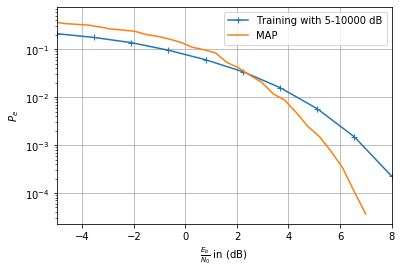

Elapsed : 62.38 s


In [57]:
# -*- coding: utf-8 -*-
import os
import matplotlib.pyplot as plt
import numpy as np
import keras 
import time

from keras.models import load_model

from src.communications import Transmitter, AWGNChannel, Receiver, ReceiverMode, TransmitterMode
from src.utils import ber_performance, get_basic_channel_fct, show_ber, get_fec_matrix, get_all_possible_words

# Configuration
MODULATION = 'BPSK'
FEC_MATRIX = 'POLAR_8_16'
EbN0dBs = np.linspace(-5, 8, 10)

G = get_fec_matrix(FEC_MATRIX)
channel = AWGNChannel(MODULATION, G)

k = np.size(G, 0)
n = np.size(G, 1)

block_elements = list(get_all_possible_words(k))

def get_channel_fct(encoder_model, decoder_model):
    def channel_fct(b, EbN0dB):
            # Encoder
            c = encoder_model.predict(np.array(np.split(b, len(b) // k)))
            c = c.flatten()

            # Channel
            d = channel.process(c, EbN0dB)

            # Decoder
            b_r = decoder_model.predict(np.array(np.split(d, len(d) // n)))
            b_r = b_r.flatten()
            b_r = np.round(b_r)

            return b_r, c, d
        
    return channel_fct

    
if __name__ == '__main__':
    t = time.time()
    
    # Get all trained networks
    elts = {}
    for file in os.listdir("networks/autoencoder"):
        if file.endswith(".h5"):
            [_, elt_type, elt_db] = file.replace('.h5', '').split('_')
            if elt_db not in elts.keys():
                elts[elt_db] = {}
            
            elts[elt_db][elt_type] = load_model(f'networks/autoencoder/{file}')
    
    # Plot results
    [EbN0dBs_C, BER_C] = np.loadtxt('outputs/BER_G_MAP.csv', delimiter=',')
    
    plt.figure()
    
    # Simulation
    legend = []
    symbols = ['+', 'x', 'o', '*']
    for (i, training_EbN0dB) in enumerate(elts.keys()):
        print(f'\nStart simulation with network trained at {training_EbN0dB} dB')
        legend.append(f'Training with {training_EbN0dB} dB')
        
        BER = ber_performance(
            EbN0dBs,
            get_channel_fct(
                elts[training_EbN0dB]['encoder'], 
                elts[training_EbN0dB]['decoder']
            ),
            k * 1000,
            1000
        )
        plt.plot(EbN0dBs, BER, symbols[i % len(symbols)] + '-')
        
        np.savetxt(
            f'outputs/BER_autoencoder.csv', 
            [np.array(EbN0dBs), np.array(BER)], delimiter=','
        )

    plt.plot(EbN0dBs_C, BER_C)
    plt.legend(legend + ['MAP'])
    plt.grid()
    
    plt.xlabel('$\\frac{E_b}{N_0}$ in (dB)')
    plt.ylabel('$P_e$')
    plt.yscale('log')
    plt.xlim(np.min(EbN0dBs), np.max(EbN0dBs))
    
    plt.show()
    
    # Save results

    
    print(f'Elapsed : {np.round(time.time() - t, 2)} s')
